# Fitness App data analysis

The dataset containts training data from 2013 through 2018. In the CSV file each row is a single training activity. Let's load and inspect it.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
# import data set
data = pd.read_csv(r'datasets/cardioActivities.csv', parse_dates=['Date'], index_col=0)
display(data.sample(3))
data.info()

,Activity Id,Type,Route Name,Distance (km),Duration,Average Pace,Average Speed (km/h),Calories Burned,Climb (m),Average Heart Rate (bpm),Friend's Tagged,Notes,GPX File
Date,,,,,,,,,,,,,
2015-09-24 18:28:14,949d5983-73ea-4a25-a589-87e0280b1b8e,Running,NaN,9.43,51:16,5:26,11.03,650.000000,77,138.0,NaN,TomTom MySports Watch,2015-09-24-182814.gpx
2018-11-11 14:05:12,c9627fed-14ac-47a2-bed3-2a2630c63c15,Running,NaN,10.44,58:40,5:37,10.68,774.000000,130,159.0,NaN,NaN,2018-11-11-140512.gpx
2016-07-16 17:27:12,5085cce1-bebb-48cb-8429-33ff77b6fdf3,Running,NaN,22.06,2:08:28,5:49,10.30,1524.999999,354,143.0,NaN,TomTom MySports Watch,2016-07-16-172712.gpx


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 508 entries, 2018-11-11 14:05:12 to 2012-08-22 18:53:54
Data columns (total 13 columns):
Activity Id                 508 non-null object
Type                        508 non-null object
Route Name                  1 non-null object
Distance (km)               508 non-null float64
Duration                    508 non-null object
Average Pace                508 non-null object
Average Speed (km/h)        508 non-null float64
Calories Burned             508 non-null float64
Climb (m)                   508 non-null int64
Average Heart Rate (bpm)    294 non-null float64
Friend's Tagged             0 non-null float64
Notes                       231 non-null object
GPX File                    504 non-null object
dtypes: float64(5), int64(1), object(7)
memory usage: 55.6+ KB


### Data Preprocessing


In [3]:
# Drop useless and empty columns
cols_drop = ['Activity Id', 'Route Name', '''Friend's Tagged''', 
             'Calories Burned', 'Climb (m)', 'GPX File', 'Notes']

data.drop(columns=cols_drop, inplace=True)
data.head()

,Type,Distance (km),Duration,Average Pace,Average Speed (km/h),Average Heart Rate (bpm)
Date,,,,,,
2018-11-11 14:05:12,Running,10.44,58:40,5:37,10.68,159.0
2018-11-09 15:02:35,Running,12.84,1:14:12,5:47,10.39,159.0
2018-11-04 16:05:00,Running,13.01,1:15:16,5:47,10.37,155.0
2018-11-01 14:03:58,Running,12.98,1:14:25,5:44,10.47,158.0
2018-10-27 17:01:36,Running,13.02,1:12:50,5:36,10.73,154.0


In [4]:
# Rename 'other' activities as unicycling
data['Type'].replace('Other', 'Unicycling', inplace=True)

display(data.Type.value_counts())
display(data.isnull().sum())

Running       459
Cycling        29
Walking        18
Unicycling      2
Name: Type, dtype: int64

Type                          0
Distance (km)                 0
Duration                      0
Average Pace                  0
Average Speed (km/h)          0
Average Heart Rate (bpm)    214
dtype: int64

#### Missing values

As we can see, there are 214 missing entries for the average heart rate variable.
We can fill in the missing values with an average value.<br>
When imputing the mean to fill in missing data, we need to consider that the average heart rate varies for different activities (e.g. walking vs. running).

In [5]:
# Compute the activity mean heart rate
def Activity_bpm(activity):
    return int(data[data['Type']==activity]['Average Heart Rate (bpm)'].mean())

# Split DataFrame into several, specific for each activities
df_run = data[data['Type']=='Running'].copy()
df_cyc = data[data['Type']=='Cycling'].copy()
df_walk = data[data['Type']=='Walking'].copy()

# Replace Nan by the activity heart rate mean
df_run['Average Heart Rate (bpm)'].fillna(Activity_bpm('Running'), inplace=True)
df_cyc['Average Heart Rate (bpm)'].fillna(Activity_bpm('Cycling'), inplace=True)
# average walking heart rate is around 110 BPM
df_walk['Average Heart Rate (bpm)'].fillna(110, inplace=True)

df_run.isnull().sum()

Type                        0
Distance (km)               0
Duration                    0
Average Pace                0
Average Speed (km/h)        0
Average Heart Rate (bpm)    0
dtype: int64

 ### Data visualisation
 
 As we found earlier, most of the activities in the data were running (459 out of 508). There are only 29, 18, and 2 instances for cycling, walking, and unicycling, respectively. So for now, let's focus on plotting the different running metrics.

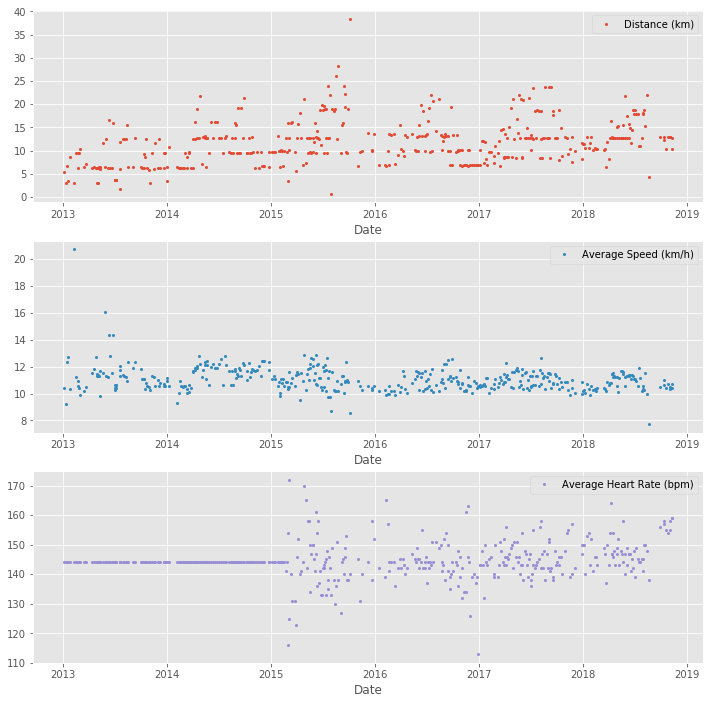

In [6]:
# Prepare data subsetting period from 2013 till 2018
run_subset = df_run.loc['2018':'2013']

# Graphs of running metrics
plt.style.use('ggplot')
run_subset.plot(figsize=(12, 12), subplots=True, sharex=False, 
               linestyle='none', marker='o', ms=2)

plt.show();

### Statistical analysis

For a runner, it can be useful to answer questions like :

    What is my average distance?
    How fast do I run?
    How often do I train?

Let's find out those information in the data.

In [7]:
# Calculate annual statistiques
run_selection = df_run.loc['2018':'2015']

display(run_selection.resample('A').mean().round(2))

,Distance (km),Average Speed (km/h),Average Heart Rate (bpm)
Date,,,
2015-12-31,13.60,11.00,143.35
2016-12-31,11.41,10.84,143.39
2017-12-31,12.94,10.96,145.25
2018-12-31,13.34,10.78,148.12


In [8]:
# Weekly averages
print('Weekly averages')
display(run_selection.resample('W').mean().mean().round(1))

# Training intensity between 2015 and 2018
n_weeks = (run_selection.index[1] - run_selection.index[-1]).days / 7

print('Average number of training per week : {:.2f}'
      .format(run_selection['Distance (km)'].count() / n_weeks))

Weekly averages


Distance (km)                12.5
Average Speed (km/h)         10.8
Average Heart Rate (bpm)    144.8
dtype: float64

Average number of training per week : 1.51


#### Visualisation with averages

Let's plot the long term averages of the distance run and heart rate with their raw data to visually compare the averages to each training session. Again, we'll use the data from 2015 through 2018.

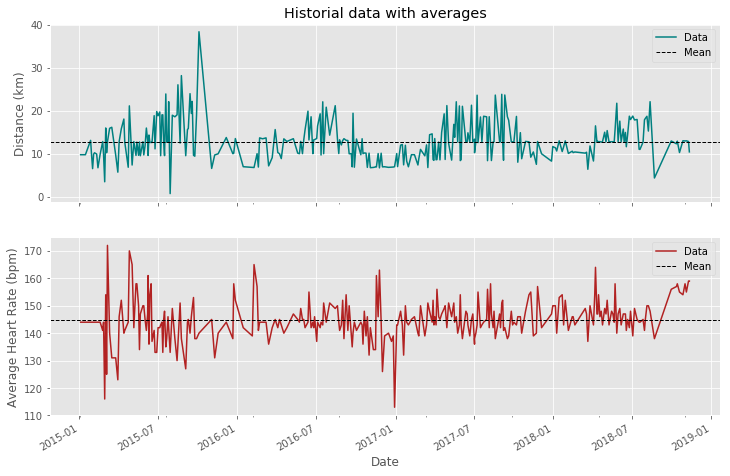

In [9]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12, 8))

# Distance chart
run_selection['Distance (km)'].plot(xticks=None, ax=ax1, c='teal')

ax1.axhline(run_selection['Distance (km)'].mean(), ls='--', lw=1, c='k')

ax1.legend(('Data', 'Mean'))
ax1.set_title('Historial data with averages')
ax1.set_ylabel('Distance (km)')

# Heart rate chart
run_selection['Average Heart Rate (bpm)'].plot(c='firebrick', ax=ax2)

ax2.axhline(run_selection['Average Heart Rate (bpm)'].mean(), 
           ls='--', lw=1, c='k')

ax2.legend(('Data', 'Mean'))
ax2.set_ylabel('Average Heart Rate (bpm)');

### Reaching the goal

Let's set a target goal of running 1000 km per year. We'll visualize the annual running distance (km) from 2013 through 2018 to see if we reached the goal each year. Only stars in the green region indicate success.

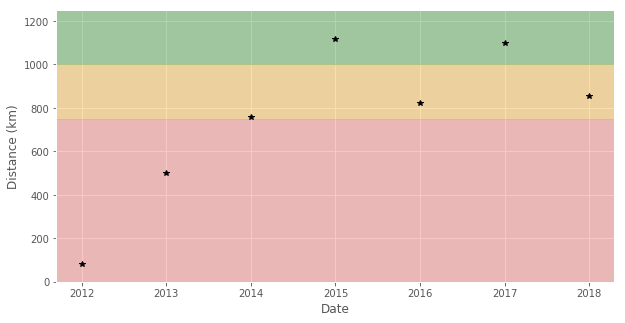

In [10]:
# Distance ran each year
total = df_run['Distance (km)'].resample('A').sum()

# Graph the target vs actual running distance
plt.figure(figsize=(10, 5))

ax = total.plot(marker='*', c='k', linestyle='none',
               ylim=([0, 1250]))

ax.set(ylabel='Distance (km)')

ax.axhspan(0, 750, color='r', alpha=0.2)
ax.axhspan(750, 1000, color='orange', alpha=0.3)
ax.axhspan(1000, 1250, color='g', alpha=0.3);

### Measuring trend and progression

Let's dive a little deeper into the data to answer a question: are we progressing in terms of running skills?

First, we'll decompose the weekly distance run and visually compare it to the raw data. A trend line will represent the weekly distance run.

We are going to use <code>statsmodels</code> library to decompose the weekly trend.

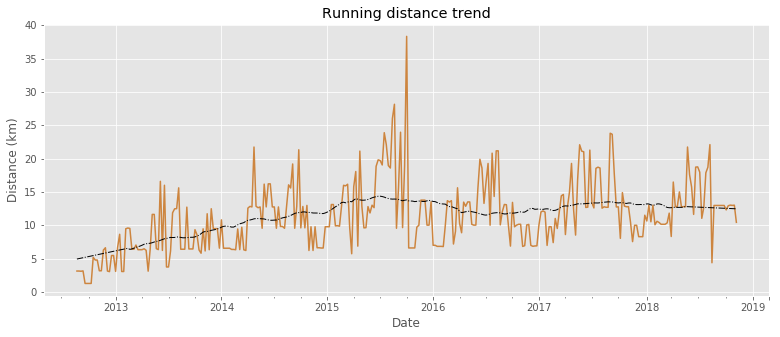

In [11]:
# Compute rolling mean
df_distance = df_run['Distance (km)'].resample('W').bfill()
mean = sm.tsa.seasonal_decompose(df_distance, extrapolate_trend='freq')

# Graph running distance across time
fig = plt.figure(figsize=(13, 5))

ax = df_distance.plot(color='peru')

# Moving average
ax = mean.trend.plot(ls='-.', color='k', lw=1)
ax.set(ylabel='Distance (km)', title='Running distance trend');

#### Training intensity

Heart rate is a popular metric used to measure training intensity. A target heart rate during moderate-intensity activities is about 50-70% of maximum heart rate, while during intense physical activity it’s about 70-85% of maximum.

We'll create a distribution plot of heart rate data by training intensity.

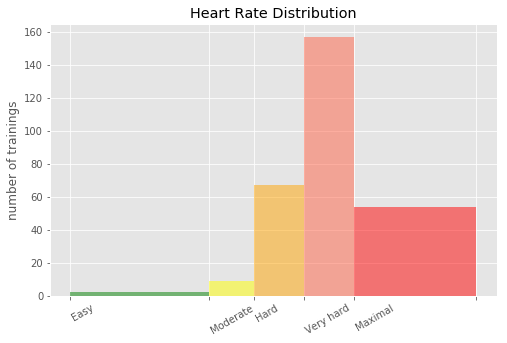

In [12]:
# Set bins
hr_ranges = [100, 125, 133, 142, 151, 173]
intensity = ['Easy', 'Moderate', 'Hard', 'Very hard', 'Maximal']
colors = ['green', 'yellow', 'orange', 'tomato', 'red']

df_hr = df_run['2018':'2015-03-01']['Average Heart Rate (bpm)']

# Histogram of training intensity
fig, ax = plt.subplots(figsize=(8, 5))

n, bins, patches = ax.hist(df_hr, bins=hr_ranges, alpha=0.5)
# Color each bin
for i in range(0, len(patches)) :
    patches[i].set_facecolor(colors[i])

ax.set(title='Heart Rate Distribution', 
      ylabel='number of trainings')

# Set xticks with the right label
ax.xaxis.set(ticks=hr_ranges)
ax.set_xticklabels(labels=intensity, rotation=30, ha='left');

#### Detailed summary

With all this data cleaning, analysis, and visualization, let's create detailed summary tables of the training.

The table will contain the summary statistics for the average speed (km/hr), climb (m), and distance (km) variables for each training activity.

In [13]:
# Select useful columns
dist_col, speed_col = ['Distance (km)'], ['Average Speed (km/h)']

# Gather data by activity
df_run_walk_cycle = df_run.append([df_walk, df_cyc]).sort_index(ascending=False)

df_summary = df_run_walk_cycle.groupby(['Type'])[dist_col + speed_col].describe()
df_totals = df_run_walk_cycle.groupby(['Type'])[dist_col + speed_col].sum()

for i in dist_col :
    df_summary[i, 'total'] = df_totals[i]
    
print('Summary statistics for different training types:')
df_summary.stack()

Summary statistics for different training types:


Average Speed (km/h)  Distance (km)
Type                                              
Cycling 25%               16.980000      15.530000
        50%               19.500000      20.300000
        75%               21.490000      29.400000
        count             29.000000      29.000000
        max               24.330000      49.180000
        mean              19.125172      23.468276
        min               11.380000      11.410000
        std                3.257100       9.451040
        total                   NaN     680.580000
Running 25%               10.495000       7.415000
        50%               10.980000      10.810000
        75%               11.520000      13.190000
        count            459.000000     459.000000
        max               20.720000      38.320000
        mean              11.056296      11.382353
        min                5.770000       0.760000
        std                0.953273       4.937853
        total                   NaN    5224.500000
Walking 25%                5.555000       1.385000
        50%                5.970000       1.485000
        75%                6.512500       1.787500
        count             18.000000      18.000000
        max                6.910000       4.290000
        mean               5.549444       1.858333
        min                1.040000       1.220000
        std                1.459309       0.880055
        total                   NaN      33.450000